# MAP 512 : Tatouage numérique par code Tardos

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats

m = 2500 # Taille du tatouage : Fixée par la capacité d'accueil du support (doit être grand pour que les pi suivent bien la distribution)
n = 100000 # Nombre d'utilisateurs : Evolue au fur et à mesure que des utilisateurs se rajoutent
t = 1/300
c = 5 # Taille de la collusion maximale considérée

## Code de Tardos
Cette section propose plusieurs fonctions pour mettre en application la méthode proposée par Tardos.
- *matrice_identifiants* calcule une matrice de $n$ identifiants de taille $m$ par la méthode de Tardos. Les paramètres $p_i$ de Bernouilli de chaque bit de l'identifiant sont tirés selon la loi de densité $f(p) = \frac{Cte}{\sqrt{p(1-p)}}\mathbb{1}_{[t,1-t]}(p)$. On doit donc avoir $t<\frac{1}{2}$.
- *score_tardos* calcule le score de Tardos de l'identifiant $x$ par rapport à $y$ sachant la distribution des $p_i$.

### Calcul de la fonction de répartition de la loi de densité $f$
Le chagement de variable $q=\sqrt{p}$ donne :
$$\int_t^x{f\left(p\right)dp} = \int_t^x{\frac{Cte\cdot dp}{\sqrt{p(1-p)}}} = \int_\sqrt{t}^\sqrt{x}{\frac{Cte\cdot dq}{2\sqrt{(1-q^2)}}} = 2\cdot Cte\left[Arcsin\left(\sqrt{x}\right)-Arcsin\left(\sqrt{t}\right)\right]$$
Donc $Cte = \frac{1}{2\left[Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)\right]}$
et la fonction de répartition de cette loi vaut $F(x)=\frac{Arcsin\left(\sqrt{x}\right)-Arcsin\left(\sqrt{t}\right)}{Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)}$ sur $[t,1-t]$.  
Puis $F^{-1}(u)=sin^2\left[Arcsin\left(\sqrt{t}\right)+u\cdot\left(Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)\right)\right]$.

In [2]:
def matrice_identifiants(n,m,t):
    # On doit avoir t < 0.5
    u = npr.rand(m)
    p = np.sin(np.arcsin(np.sqrt(t)) + u*(np.arcsin(np.sqrt(1-t))-np.arcsin(np.sqrt(t))))
    p = p*p
    X = np.array(npr.binomial(1,p,(n,m)))
    return p,X

def generation_innocents(n,p):
    m = len(p)
    X = np.array(npr.binomial(1,p,(n,m)))
    return X

def score_tardos(x,y,p):
    return np.sum((1-2*(x*(1-y)+y*(1-x)))*((np.sqrt((1-p)/p))**(2*x-1)))

def score_tardos_matrix(X,y,p):
    return np.apply_along_axis(lambda x: score_tardos(x,y,p), axis=1, arr=X)

In [3]:
p,X = matrice_identifiants(n, m, t)
score_tardos(npr.binomial(1,p,m), X[0], p)

-56.18032267293658

## Monte Carlo naïf pour trouver la p-valeur
Soit $y$ un identifiant trouvé dans une copie pirate et $x$ l'identifiant d'un utilisateur.  
On suppose les $p_i$ connus.  
Quelle est la probabilité $p_x$ qu'un innocent ai un score supérieur à celui de x ?  
Pour répondre à cette question nous utiliserons un estimateur Monte Carlo naïf dans un premier temps:
$$\hat{p_x}=\frac{1}{N}\overset{N}{\underset{k = 1}\sum}{\mathbb{1}_{S\left(X_k\right)\geq S(x)}}\ \ \text{avec}\ \ X_k \overset{iid}{\sim}\left[\mathcal{Bernoulli}(p_i)\right]_{1\leq i\leq m}$$

In [4]:
def MC_naif(N,p,x,y):
    X = np.array(npr.binomial(1,p,(N,m)))
    score = score_tardos_matrix(X,y,p)
    return np.average(score >= score_tardos(x,y,p))

def MC_naif_score(p,score_lim,y,N=1000):
    X = np.array(npr.binomial(1,p,(N,m)))
    score = score_tardos_matrix(X,y,p)
    #print('Var(Score) : '+str(np.average(score**2) - np.average(score)**2))
    return np.average(score >= score_lim)

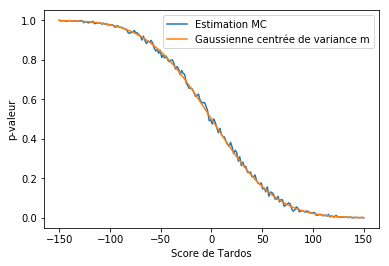

In [37]:
Score = np.linspace(-150,150,200)
Y = npr.binomial(1,p,m)
p_value = []
for score_lim in Score:
    p_value.append(MC_naif_score(p,score_lim,Y))
plt.plot(Score,p_value,label='Estimation MC')
p_value_reel = scipy.stats.norm.sf(Score,0,np.sqrt(m))
plt.plot(Score,p_value_reel,label='Gaussienne centrée de variance m')
plt.xlabel('Score de Tardos')
plt.ylabel('p-valeur')
plt.legend()
plt.savefig("p_valeur_MC_naif.png",dpi=1000)
plt.show()

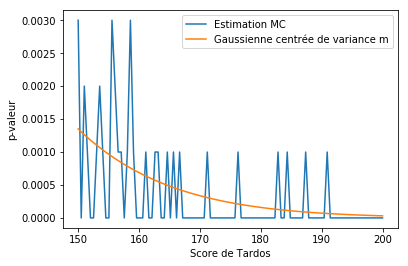

In [38]:
Score = np.linspace(150,200,100)
Y = npr.binomial(1,p,m)
p_value = []
for score_lim in Score:
    p_value.append(MC_naif_score(p,score_lim,Y))
plt.plot(Score,p_value,label='Estimation MC')
p_value_reel = scipy.stats.norm.sf(Score,0,np.sqrt(m))
plt.plot(Score,p_value_reel,label='Gaussienne centrée de variance m')
plt.xlabel('Score de Tardos')
plt.ylabel('p-valeur')
plt.legend()
plt.savefig("p_valeur_MC_naif_zoom.png",dpi=1000)
plt.show()

## Stratégie de la collusion
Nous allons proposer et comparer 3 stratégies pour la collusion :
- *vote_majoritaire* : suit le principe du vote majoritaire
- *entrelacement* : un membre de la collusion est tiré uniformément pour chaque bit
- *pile_ou_face* : à chaque bit repérable par la collusion est attribué la valeur 1 avec probabilité $\frac{1}{2}$
- *vote_minoritaire* : suit le principe du vote minoritaire, tout en suivant la *marking assumption*

Nous rappelons que ces 3 stratégies respectent la *marking assumption* qui stipule : $$\forall i\in[|1,m|]  \ \ X_{1i}=X_{2i}=\cdots=X_{ci}\Rightarrow\rho_{C}(X)_{i} = X_{1i}$$
Avec $C = [|1,c|]$ la collusion et $\rho_C$ leur strategie.

In [4]:
def vote_majoritaire(C):
    return np.round(np.average(C,axis=0))

def entrelacement(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    c = len(C)
    u = npr.randint(low=0, high=c, size=m)
    return C[u,:].diagonal()

def pile_ou_face(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    u = npr.randint(low=0, high=2, size=m)
    mask = C[0] == np.average(C,axis=0)
    for i in range(m):
        if mask[i]:
            u[i] = C[0][i]
    return u
    
def vote_minoritaire(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    u = 1 - np.round(np.average(C,axis=0))
    mask = C[0] == np.average(C,axis=0)
    for i in range(m):
        if mask[i]:
            u[i] = C[0][i]
    return u

In [7]:
C = X[0:3]
vote_majoritaire(C)
entrelacement(C)
pile_ou_face(C)

array([1, 1, 1, ..., 0, 1, 0])

## Distribution empirique des scores des innocents et des colludés
Le but de cette partie est de fournir une repésentation empirique de la distribution des scores des innocents face à une réponse pirate trouvée, et de la comparer à celles des membres de la collusion.  
Cette étude se fait pour les trois stratégies envisagées ci-dessus.

In [5]:
def choix_collusion(X,c):
    C_indices = npr.choice(range(len(X)), size=c, replace=False)
    return C_indices
    
def calcul_marque_pirate(C,strategie):
    return strategie(C)

def prendre_C(indices_collusion,X):
    return X[indices_collusion,:]

def calcul_scores(X,p,c,strategie):
    n = len(X)
    # Choix de la collusion
    C_indices = choix_collusion(X,c)
    C = prendre_C(C_indices,X)
    # Etablissement de la marque pirate
    y = calcul_marque_pirate(C,strategie)
    # Calculs des scores des innocents
    Innocents_indices = list(set(range(n)) - set(C_indices))
    X_innocents = X[Innocents_indices,:]
    Scores_innocents = score_tardos_matrix(X_innocents,y,p)
    # Calcul des scores des colludés
    Scores_colludes = score_tardos_matrix(C,y,p)
    return Scores_innocents,Scores_colludes

def affichage(Scores_innocents,Scores_colludes,nom_strategie):
    plt.hist(Scores_colludes, bins=100, density=True, color='r', label='Colludés')
    # Estimation de la densité par noyau gaussien pour les innocents
    densite_innocents = scipy.stats.gaussian_kde(Scores_innocents)
    x_plot = np.linspace(-200,400,2000)
    plt.plot(x_plot, densite_innocents.evaluate(x_plot), color='g', label='Innocents')
    plt.xlabel('Score de Tardos')
    plt.axvline(x=np.max(Scores_innocents),label="Innocent avec le plus grand score")
    plt.plot(x_plot,scipy.stats.norm.pdf(x_plot,0,np.sqrt(m)),linestyle=':',label="Gaussienne centrée de variance m")
    plt.ylim(0,0.015)
    plt.legend()
    plt.savefig("distribution_innocents_vs_"+nom_strategie+".png",dpi=1000)
    plt.show()
    
def calcul_scores_colludes(X,p,c,strategie):
    n = len(X)
    Scores_colludes = []
    N = 10000
    for k in range(N):
        # Choix de la collusion
        C_indices = choix_collusion(X,c)
        C = prendre_C(C_indices,X)
        # Etablissement de la marque pirate
        y = calcul_marque_pirate(C,strategie)
        # Calcul des scores des colludés
        Scores_colludes.append(score_tardos_matrix(C,y,p))
        if k==0:
            # Calculs des scores des innocents
            Innocents_indices = list(set(range(n)) - set(C_indices))
            X_innocents = X[Innocents_indices,:]
            Scores_innocents = score_tardos_matrix(X_innocents,y,p)
    return Scores_innocents,np.array(Scores_colludes).flatten()

def affichage_colludes(Scores_innocents,Scores_colludes,nom_strategie):
    # Estimation des densités par noyau gaussien
    densite_innocents = scipy.stats.gaussian_kde(Scores_innocents)
    densite_coupables = scipy.stats.gaussian_kde(Scores_colludes)
    mu = np.average(Scores_colludes)
    x_plot = np.linspace(-200,600,2000)
    plt.plot(x_plot, densite_innocents.evaluate(x_plot), color='g', label='Innocents')
    plt.plot(x_plot, densite_coupables.evaluate(x_plot), color='r', label='Colludés')
    plt.xlabel('Score de Tardos')
    plt.axvline(x=np.max(Scores_innocents),label="Innocent avec le plus grand score")
    plt.plot(x_plot,scipy.stats.norm.pdf(x_plot,mu,np.sqrt(m)),linestyle=':',label="Gaussienne de variance m")
    plt.ylim(0,1.25*scipy.stats.norm.pdf(0,0,np.sqrt(m)))
    plt.legend(loc='upper right')
    plt.savefig("distribution_innocents_colludes_"+nom_strategie+".png",dpi=1000)
    plt.show()

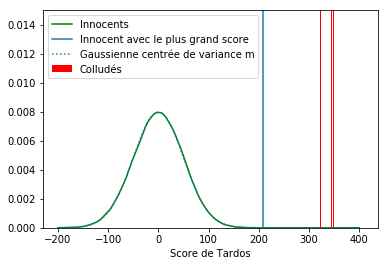

In [12]:
si,sc = calcul_scores(X,p,c,vote_majoritaire)
affichage(si,sc,"vote_majoritaire")

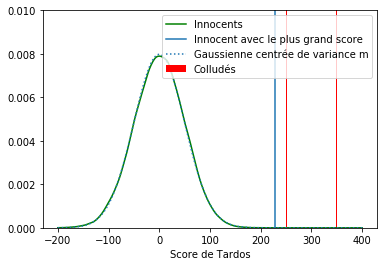

In [10]:
si,sc = calcul_scores(X,p,c,entrelacement)
affichage(si,sc,"entrelacement")

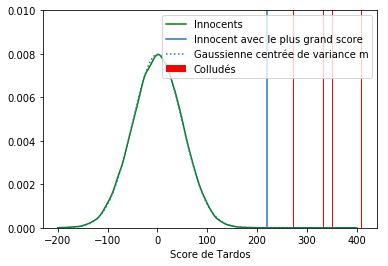

In [11]:
si,sc = calcul_scores(X,p,c,pile_ou_face)
affichage(si,sc,"pile_ou_face")

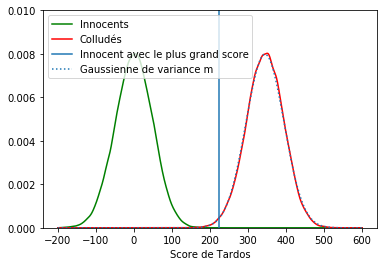

In [12]:
si,sc = calcul_scores_colludes(X,p,c,vote_majoritaire)
affichage_colludes(si,sc,"vote_majoritaire")

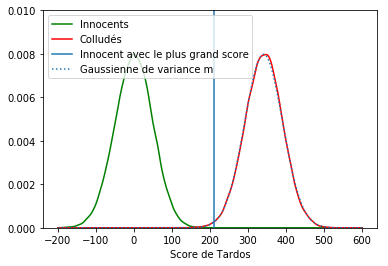

In [13]:
si,sc = calcul_scores_colludes(X,p,c,entrelacement)
affichage_colludes(si,sc,"entrelacement")

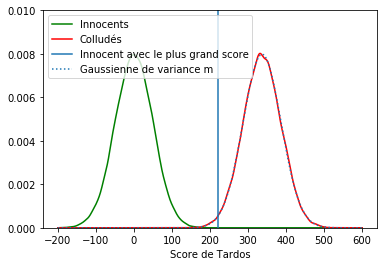

In [14]:
si,sc = calcul_scores_colludes(X,p,c,pile_ou_face)
affichage_colludes(si,sc,"pile_ou_face")

Ici on va faire varier m pour voir le décollement des deux gaussiennes.

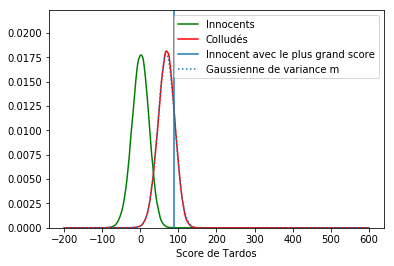

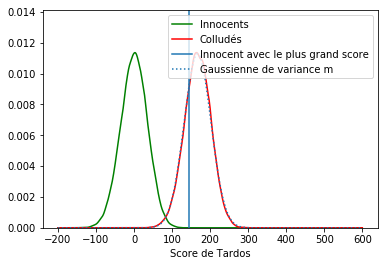

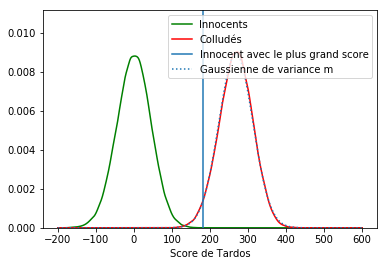

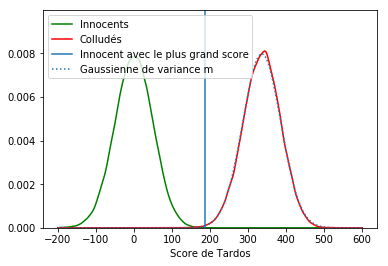

In [9]:
for k in [500,1250,2000,2500]:
    m = k
    p,X = matrice_identifiants(n,m,t)
    si,sc = calcul_scores_colludes(X,p,c,vote_majoritaire)
    affichage_colludes(si,sc,"m_"+str(k))

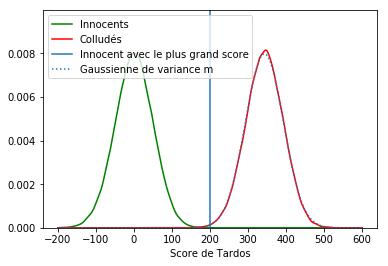

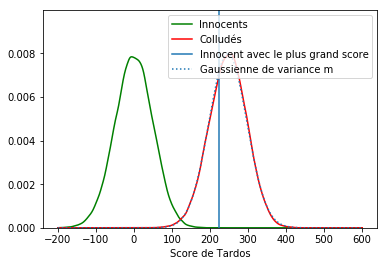

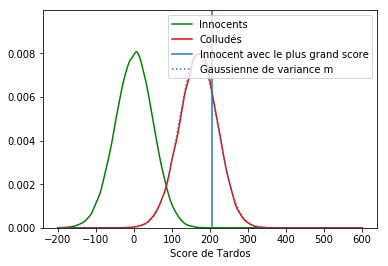

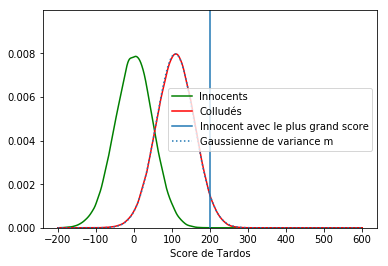

In [7]:
for k in [5,7,10,15]:
    c = k
    p,X = matrice_identifiants(n,m,t)
    si,sc = calcul_scores_colludes(X,p,c,vote_majoritaire)
    affichage_colludes(si,sc,"c_"+str(k))

## Adaptative Multilevel Splitting

In [7]:
def tri_vect(Z):
    # Ordonne le vecteur par score, qui est stocké en première coordonnée
    return Z[Z[:,0].argsort(),:]

def clonage(X,Z):
    # Va clonner les tatouages des utilisateurs tirés avec un score inférieur à la médiane 
    #    sur ceux supérieurs à cette dernière
    Z = tri_vect(Z)
    n = len(X)
    pas = int(n/2)
    mediane = Z[pas]['Score']
    for k in range(pas):
        j_1 = Z[k]['Indice']
        j_2 = Z[k+pas]['Indice']
        # Remplace l'utilisateur avec le i-ième score plus bas par le median + i
        X[j_1] = X[j_2].copy()
        Z[k]['Score'] = Z[k+pas]['Score']
    return X,Z,mediane

In [8]:
def etape_MH(X,Z,p,y,J,T):
    X,Z,seuil = clonage(X,Z)
    n = len(X)
    # On fait varier seulement la moitié des joueurs avec les scores les plus faibles
    for t in range(T):
        #compt = 0
        #compt2 = 0
        #delta = 0
        for j in range(int(n/2)):
            # Tirage des J bits du tatouage qui vont changer
            bits_a_changer = npr.choice(m,size=J,replace=False) 
            # Tirage des J bits à changer
            nouveaux_bits = npr.binomial(1,p[bits_a_changer])# aleatoire_k_bit 
            delta_score = (score_tardos(nouveaux_bits,y[bits_a_changer],p[bits_a_changer])
                - score_tardos(X[Z[j]['Indice'],bits_a_changer],y[bits_a_changer],p[bits_a_changer])) 
            # Critère de Metropolis-Hasting pour le rejet
            if(Z[j]['Score'] + delta_score >= seuil):
                #compt += 1
                X[int(Z[j]['Indice']),bits_a_changer] = nouveaux_bits
                #if np.abs(delta_score)==0:
                #   compt2+=1
                #delta += np.abs(delta_score)
                Z[j]['Score'] += delta_score
        #print('Ratio de sauts : '+str(2*compt/n))
        #print('Ratio de sauts statiques : '+str(compt2/(0.01+compt)))
        #print('Ecart moyen : '+str(delta/(0.01+compt)))
    Z = tri_vect(Z)
    nouveau_seuil = Z[int(n/2)]['Score']
    return X,Z,nouveau_seuil           
                
def AMS(p,y,score_lim,J,T,N):
    # p est le vecteur des p_i
    # y est la marque pirate
    # score_lim est le score pour lequel on veut calculer la p-value
    # HYPERPARAMETRES:
    # J est la quantite de bits à changer
    # T est la quantite de saut dans l'algorithme de Metropolis-Hasting
    # N le nombre de points pour chaque étape
    X = generation_innocents(N,p)
    S = score_tardos_matrix(X,y,p)
    # Z est le vector des scores avec en deuxième coordonnée l'identifiant (indice de ligne dans X) de l'utilisateur
    Z = np.zeros(N,dtype=[('Score',float),('Indice',int)])
    # Z[i,1] est le i-ème utilisateur dans la liste qui a originé S
    Z['Score'] = S
    Z['Indice'] = range(N)
    Z = tri_vect(Z)
    seuil = Z[len(X)//2]['Score']
    # Stockage de Z pour pouvoir afficher la distribution à la fin
    Z_mem =[Z]
    print(seuil)
    mem_seuil = seuil
    while (seuil<score_lim):
        X,Z,seuil = etape_MH(X,Z,p,y,J,T)
        #plt.hist(Z['Score'], bins=100, density=True)
        #plt.show()
        print(seuil)
        Z_mem.append(Z)
    return Z_mem

def estimation_proba(Z_mem,score_lim):
    n = len(Z_mem[0])
    i = 0
    while (i<len(Z_mem) and score_lim > Z_mem[i][int(n/2)]['Score']):
        i += 1
    # On a donc depasser le seuil
    # On va maintenant corriger la dernière probabilité
    p_final = np.average(Z_mem[i]['Score'] >= score_lim)
    return (1/2)**(i)*p_final

def estimation_AMS(p,y,score_lim,J,T,N):
    return estimation_proba(AMS(p,y,score_lim,J,T,N),score_lim)

def affichage_distribution_estimee(Z_mem,s_min,s_max,titre=''):
    Score = np.linspace(s_min,s_max,200)
    p_value = []
    for score_lim in Score:
        p_value.append(estimation_proba(Z_mem,score_lim))
    plt.plot(Score,p_value,label='Estimation AMS')
    p_value_reel = scipy.stats.norm.sf(Score,0,np.sqrt(m))
    plt.plot(Score,p_value_reel,label='Gaussienne centrée de variance m')
    plt.xlabel('Score de Tardos')
    plt.ylabel('p-valeur')
    plt.legend()
    plt.savefig("p_valeur_AMS"+titre+".png",dpi=1000)
    plt.show()
    
def affichage_distribution_estimee_log(Z_mem,s_min,s_max,titre=''):
    Score = np.linspace(s_min,s_max,200)
    p_value = []
    for score_lim in Score:
        p_value.append(estimation_proba(Z_mem,score_lim))
    plt.plot(Score,p_value,label='Estimation AMS')
    p_value_reel = scipy.stats.norm.sf(Score,0,np.sqrt(m))
    plt.plot(Score,p_value_reel,label='Gaussienne centrée de variance m')
    plt.xlabel('Score de Tardos')
    plt.ylabel( 'p-valeur')
    plt.yscale("log")
    plt.legend()
    plt.savefig("p_valeur_AMS"+titre+"_log.png",dpi=1000)
    plt.show()

__Attention :__ la cellule ci dessous est un  peu longue à évaluer.

In [103]:
J = 5
T = 40
N = 3000
Y = npr.binomial(1,p,m)
Z_mem = AMS(p,Y,200,J,T,N)
p_valeur = estimation_proba(Z_mem,200)
p_valeur_reelle = scipy.stats.norm.sf(200,0,np.sqrt(m))
print(p_valeur)
print(p_valeur_reelle)

-0.9518173563082186
32.48773072709351
55.83637746204662
74.00129728304881
90.38124180152069
103.90559567473255
116.6095291319185
127.56550141908379
137.70024687829098
147.824688878393
157.15799690459338
166.2109891960619
174.80971069238214
183.1966589843301
190.49263153681014
197.9730149977981
205.20617697406706
1.2578328450520834e-05
3.167124183311986e-05


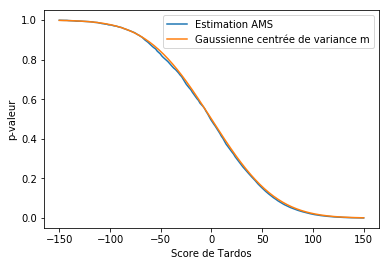

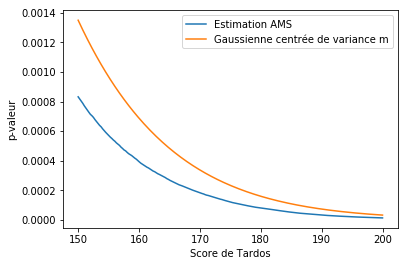

In [104]:
affichage_distribution_estimee(Z_mem,-150,150,titre='')
affichage_distribution_estimee(Z_mem,150,200,titre='_zoom')

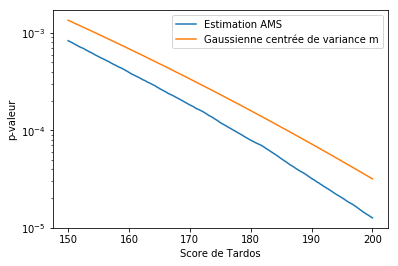

In [105]:
affichage_distribution_estimee_log(Z_mem,150,200,titre='_zoom')

## Fonction de score pour accuser un deuxième pirate

Dans cette partie on suppose qu'un pirate est connu, il a par exemple reconnu les faits ou la probabilité d'innocence est suffisament faible pour l'inculper. Le but est de tiré partie de cette information pour accuser un deuxième pirate, s'il y en a un et éventuelement le reste de la collusion. Pour ce faire, nous avons essayé deux fonctions de score différentes, toutes les deux indépendantes de la strategie de la collusion.

La première stratégie est d'ajouter au code de Tardos une comparaison avec le tatouage du pirate connu. La seconde stratégie est de n'évaluer le score que sur les bits de tatouage sur lesquels la marque pirate et le pirate connu coïncident. En effet, ces bits sont encore "cachés", c'est-à-dire qu'ils peuvent encore faire partie des bits soumis à la _marking assumption_.

In [20]:
#Creation de Z

def create_Z(X,y,p):
    S= score_tardos_matrix(X,y,p)
    Z = np.zeros((np.shape(X)[0],2)).astype(object)
    Z[:,0]=S
    Z[:,1]=np.arange(len(S)).astype(int)
    Z= tri_vect(Z)
    return Z

#Trier Z par joueur

def tri_Z_par_joueur(Z):
    return Z[Z[:,1].argsort(),:]

# Nouvelle prise des colludes

def score_sachant(x,y,p):
    return score_tardos(x,y,p)
    
def etape_MH_sachant(X,Z,p,y,J,T):
    X,Z,seuil = clonage(X,Z)
    n = len(X)
    # Tirage les J bits du tatouage qui vont changer
    bits_a_changer = npr.choice(m,size=J,replace=False) 
    # On fait varier seulement la moitié des joeurs avec les scores les plus faibles
    for t in range(T):
        for j in range(n//2):
            # Copie du tatouage du j-ième utilisateur
            x_j = X[int(Z[j,1]),:]
            # Tirage des J bits à changer
            for k in range(J): 
                x_j[bits_a_changer[k]] = np.random.binomial(1,p[bits_a_changer[k]])# aleatoire_k_bit 
            score_j = score_sachant(x_j,y,p) 
            # Critère de Metropolis-Hasting pour le rejet
            if(score_j >= seuil):
                X[Z[j,1],:] = x_j
                Z[j,0] = score_j
    Z = tri_vect(Z)
    nouveau_seuil = Z[n//2,0]
    return X,Z,nouveau_seuil     



def proba_sachant_colludes(p,y,score_lim,J,T,N,p_valeur):
    X = generation_innocents(N,p)
    Z = create_Z(X,y,p)
    proba=1
    seuil = Z[len(X)//2,0]
    
    i = 0
    while (seuil<score_lim) and proba>p_valeur:
        X,Z,seuil = etape_MH_sachant(X,Z,p,y,J,T)
        proba=(1/2)**i
        i += 1
    # On a donc depasser le seuil
    # On va maintenant corrigé la dernière probabilité
    p_final = np.average(Z[:,0] <= score_lim)
    return (1/2)**(i-1)*p_final

    
def visualiser(Z_innocent,Z_acuses):
    #va plotter les innocents et les coupables, et le innocent avec le plus grand score
    plt.hist(Z_innocent[:,0],bins=20)
    for i in Z_acuses[:,0]:
        plt.axvline(x=i,color='r')
    plt.axvline(x=Z_innocent[-1,0],color='b')
    plt.plot()


def test_(i,cache,X,Z,y,C_indices,p):
    #i est le i-eme plus grand score
    #cache est la list des elements qui sont encore dans la marking assumption

    acuse_i=Z[-1*i,1]
    code_acuse_i=X[acuse_i,:]
    antes=np.shape(cache)[0]
    k=0
    for j in cache:
        if code_acuse_i[j]!=y[j]:
            cache.remove(j)
            k+=1

    Indices_pegos= list(set(range(m))-set(cache))
    
    Innocents=list(set(range(n))-set(C_indices))
    
    X_nouvelle = X[:,Indices_pegos]
    X_innocents =X_nouvelle[Innocents,:]
    X_coupables =X_nouvelle[C_indices, :]
    
    p_ligne=p[Indices_pegos]
    y_ligne=y[Indices_pegos]
    Z_ligne=create_Z(X_nouvelle,y_ligne,p_ligne)
    Z_innocent=create_Z(X_innocents,y_ligne,p_ligne)
    Z_coupables=create_Z(X_coupables,y_ligne,p_ligne)
    print("En calculant les scores, supprimant les points découverts du dernier accusé, observon la ligne blue et celles rouges")
    visualiser(Z_innocent,Z_coupables)
    
    return cache


#Deuxieme score tardos propose, plus naif
def somme(Z,code_pris,i,X,C_indices):
    Z=tri_Z_par_joueur(Z)

    Z[:,0]=Z[:,0]*np.sqrt(i)
    Z1=tri_Z_par_joueur(create_Z(X,code_pris,p))
    Z1[:,0]=(Z1[:,0]+Z[:,0])/np.sqrt(i+1)
    
    innocents = list(set(range(n))-set(C_indices))
    z1_innocents= tri_vect(Z1[innocents])
    z1_coupables=tri_vect(Z1[C_indices])
    print("Observons que les innocents avec score plus grand, la ligne blue est devant des coupables")
    visualiser(z1_innocents,z1_coupables)
    
    return Z1

In [9]:
score_lim = 10
p_valeur = 1e-3
C_indices = choix_collusion(X,c)
C = prendre_C(C_indices,X)
y = calcul_marque_pirate(C,pile_ou_face)

In [16]:
Innocents_indices = list(set(range(n)) - set(C_indices))

print("Les coupables sont indices par:",C_indices)

X_innocents=X[Innocents_indices,:]
Z_innocents=create_Z(X_innocents,y,p)
X_coupables=X[C_indices,:]
Z_coupables=create_Z(X_coupables,y,p)
Z=create_Z(X,y,p)

Les coupables sont indices par: [79447  9993 26055 79384 32311]


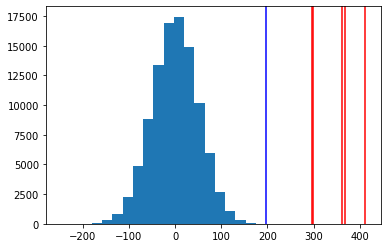

In [17]:
acusado= Z[-1,1]
codigo=X[acusado,:]
visualiser(Z_innocents,Z_coupables)
H=list(Z[-c-1:,1])

Observons que les innocents avec score plus grand, la ligne blue est devant des coupables


array([[-89.3873702655033, 0],
       [-159.61649706680006, 1],
       [-126.28916770681472, 2],
       ...,
       [13.041966132168668, 99997],
       [14.46893914276519, 99998],
       [-82.45051729280416, 99999]], dtype=object)

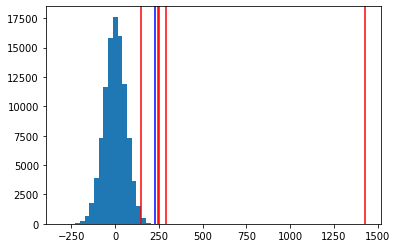

In [18]:
somme(Z,codigo,1,X,C_indices)

En calculant les scores, supprimant les points découverts du dernier accusé, observon la ligne blue et celles rouges


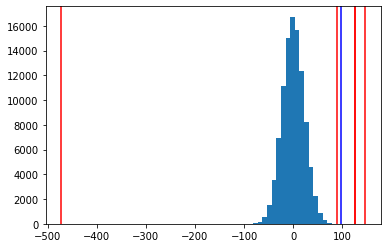

En calculant les scores, supprimant les points découverts du dernier accusé, observon la ligne blue et celles rouges


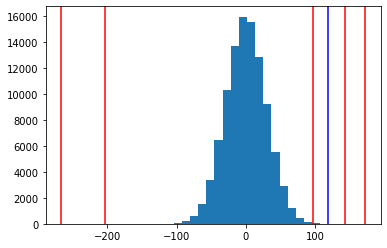

En calculant les scores, supprimant les points découverts du dernier accusé, observon la ligne blue et celles rouges


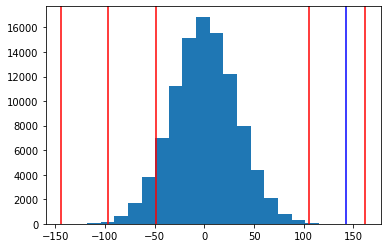

En calculant les scores, supprimant les points découverts du dernier accusé, observon la ligne blue et celles rouges


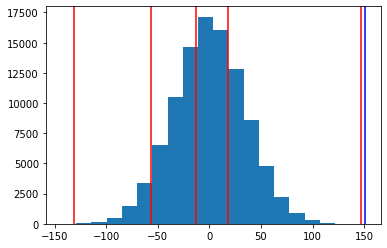

En calculant les scores, supprimant les points découverts du dernier accusé, observon la ligne blue et celles rouges


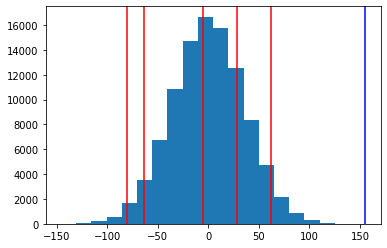

In [21]:
hidden=[i for i in range(m)]
for k in range(1,c+1):
    hidden=test_(k,hidden,X,Z,y,C_indices,p)
    plt.show()